# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
from matplotlib import pyplot as plt
import matplotlib; matplotlib.font_manager._rebuild()
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/seed=(\d+)/'
             'lambda=(\d+\.\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        seed = int(m.group(5))
        l = float(m.group(6))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              l, logfile_path))
    return logfile_paths

In [4]:
labels = {"allox": "AlloX",
          "gandiva": "LAS w/ Gandiva SS",
          "fifo": "FIFO",
          "fifo_perf": "Gavel",
          "fifo_packed": "Gavel w/ SS",
          "finish_time_fairness": "FTF",
          "finish_time_fairness_perf": "Gavel",
          "max_min_fairness": "LAS",
          "max_min_fairness_perf": "Gavel",
          "max_min_fairness_packed": "Gavel w/ SS"}

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy, seed=None):
    if seed is None:
        return sorted([(x[5], x[6], x[4]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy])
    else:
        return sorted([(x[5], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == seed])

In [6]:
def plot_metric_vs_inverse_lambda(v100s, p100s, k80s,
                                  policies, metric_fn,
                                  metric_label,
                                  xmax=None,
                                  ymax=None,
                                  output_filename=None,
                                  extrapolate=False):
    plt.figure(figsize=(6, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "policy": []}
    print(policies)
    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy)))
        lambdas = [x[0] for x in relevant_logfile_paths]
        input_job_rates = [3600.0 / x for x in lambdas]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        seeds = [x[2] for x in relevant_logfile_paths]
        policies = [labels[policy] for i in range(len(metrics))]

        data["input_job_rate"] += input_job_rates
        data["metric"] += metrics
        data["seed"] += seeds
        data["policy"] += policies
        if len(input_job_rates) > 0 and extrapolate:
            data["input_job_rate"] += [max(input_job_rates) + 0.2]
            data["metric"] += [105.0]
            data["seed"] += [0]
            data["policy"] += [labels[policy]]
    import pandas as pd
    df = pd.DataFrame(data)
    grouped_df = df.groupby(["policy", "input_job_rate"])
    for name_of_the_group, group in grouped_df:
        print(name_of_the_group)
        print(group.mean())

    sns.lineplot(x='input_job_rate', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    leg = plt.legend(loc='upper left', frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

In [7]:
import random
import sys; sys.path.append("../../..")
from job_table import JobTable

def get_job_durations(seed, generate_multigpu_jobs):
    job_generator = random.Random()
    job_generator.seed(seed+2)
    
    job_durations = []
    for i in range(5000):
        r = job_generator.uniform(0, 1)
        scale_factor = 1
        if 0.7 <= r <= 0.8:
            scale_factor = 2
        elif 0.8 <= r <= 0.95:
            scale_factor = 4
        elif 0.95 <= r:
            scale_factor = 8
        if not generate_multigpu_jobs:
            scale_factor = 1
        if job_generator.random() >= 0.8:
            job_duration = 60 * (10 ** job_generator.uniform(3, 4))
        else:
            job_duration = 60 * (10 ** job_generator.uniform(1.5, 3))

        while True:
            job_template = job_generator.choice(JobTable)
            if (scale_factor == 1 or
                (scale_factor > 1 and job_template.distributed)):
                break
                
        job_durations.append((job_duration, job_template, scale_factor))
    return job_durations

In [8]:
def get_jcts(logfile_path, seed, min_job_id=None, max_job_id=None):
    job_completion_times = []
    job_durations = get_job_durations(seed, generate_multigpu_jobs=True)
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_duration, job_template, scale_factor = job_durations[job_id]
                        job_completion_times.append(
                            (job_completion_time, job_duration))
    return [(x[0] / 3600.0, x[1] / 3600.0) for x in job_completion_times]

In [9]:
def plot_jct_cdf(v100s, p100s, k80s,
                 max_input_job_rate,
                 policies,
                 min_job_id, max_job_id,
                 finish_time_fairness=False,
                 output_directory=None):
    
    lambdas = list(set([x[5] for x in logfile_paths]))
    lambdas.sort(reverse=True)
    print(policies)

    for l in lambdas:
        handles_in_legend = []
        labels_in_legend = []
        
        input_job_rate = 3600.0 / l
        if input_job_rate > max_input_job_rate:
            continue
        print("Input job rate: %.2f" % input_job_rate)
        
        plt.figure(figsize=(8, 3))
        axes = [
            plt.subplot2grid((1, 2), (0, 0), rowspan=1),
            plt.subplot2grid((1, 2), (0, 1), rowspan=1),
        ]
        titles = ["Short jobs", "Long jobs"]

        if finish_time_fairness:
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, "isolated", seed=0)))
            relevant_logfile_paths = [x for x in relevant_logfile_paths
                                      if x[0] == l]
            if len(relevant_logfile_paths) != 1:
                continue
            isolated_jcts = get_jcts(relevant_logfile_paths[0][1],
                                     seed=0,
                                     min_job_id=min_job_id,
                                     max_job_id=max_job_id)
            isolated_jcts.sort(key=lambda x: x[1])
        linestyles = ['--', '-.', ':', '--', '-.']
        for i, policy in enumerate(policies):
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy, seed=0)))
            relevant_logfile_paths = [x for x in relevant_logfile_paths
                                      if x[0] == l]
            if len(relevant_logfile_paths) != 1:
                continue
            jcts = get_jcts(relevant_logfile_paths[0][1],
                            seed=0,
                            min_job_id=min_job_id,
                            max_job_id=max_job_id)
            jcts.sort(key=lambda x: x[1])
            if finish_time_fairness:
                jcts = [x[0] / y[0] for (x, y) in zip(jcts, isolated_jcts)]
            else:
                jcts = [x[0] for x in jcts]
                
            print("%s: %.2f" % (policy, np.mean(jcts)))
            partition_point = int(len(jcts) * 0.8)
            jcts = np.split(np.array(jcts), [partition_point])
            for j, (ax, jcts_segment) in enumerate(zip(axes, jcts)):
                jcts_segment.sort()
                percentiles = [(i+1) / len(jcts_segment)
                               for i in range(len(jcts_segment))]

                if "Gavel" in labels[policy]:
                    handle = ax.plot(jcts_segment, percentiles,
                                     color=current_palette[i],
                                     linestyle='-',
                                     linewidth=3)
                else:
                    handle = ax.plot(jcts_segment, percentiles,
                                     color=current_palette[i],
                                     linestyle=linestyles[i])
                if j == 0:
                    handles_in_legend.append(handle[0])
                    labels_in_legend.append(labels[policy])

        for i, (ax, title) in enumerate(zip(axes, titles)):
            if finish_time_fairness:
                ax.set_xlabel("FTF" + "\n" + title)
                ax.set_xlim([0, 4])
                ax.set_xticks([0, 1, 2, 3, 4])
            else:
                ax.set_xlabel("JCT (hrs, log2)" + "\n" + title)
                ax.set_xscale('log', basex=2)
                ax.xaxis.set_major_locator(plt.LogLocator(base=2, numticks=4))
            if i == 0:
                ax.set_ylabel("Fraction of jobs")
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            if i > 0:
                ax.set_yticklabels(["", "", "", "", "", ""])
            ax.set_ylim([0, 1.0])
        sns.despine()
    
        leg = plt.figlegend(handles=handles_in_legend,
                            labels=labels_in_legend,
                            ncol=3, frameon=False,
                            loc='upper center')
        bb = leg.get_bbox_to_anchor().inverse_transformed(
            axes[1].transAxes)
        bb.y0 += 0.22
        bb.y1 += 0.22
        leg.set_bbox_to_anchor(bb, transform=axes[1].transAxes)
        
        if output_directory is not None:
            output_filename = os.path.join(output_directory,
                                           "input_job_rate=%d.pdf" % (input_job_rate * 10))
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')
        
        plt.show()

# Plot average JCT versus input job rate

In [10]:
def average_jct_fn(logfile_path, min_job_id=None, max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_completion_times.append(
                            job_completion_time)
    if len(job_completion_times) == 0:
        return 110.0
    return np.mean(job_completion_times) / 3600

In [11]:
logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/deepak/gpusched/scheduler/logs/multi_gpu_continuous_jobs_final/"))

['fifo', 'fifo_perf', 'fifo_packed']
('FIFO', 0.2)
input_job_rate     0.200000
metric            17.294259
seed               1.000000
dtype: float64
('FIFO', 0.4)
input_job_rate     0.400000
metric            17.325454
seed               1.000000
dtype: float64
('FIFO', 0.6)
input_job_rate     0.6000
metric            17.5529
seed               1.0000
dtype: float64
('FIFO', 0.8)
input_job_rate     0.80000
metric            17.84437
seed               1.00000
dtype: float64
('FIFO', 1.0)
input_job_rate     1.000000
metric            18.363202
seed               1.000000
dtype: float64
('FIFO', 1.2)
input_job_rate     1.200000
metric            19.255351
seed               1.000000
dtype: float64
('FIFO', 1.4000000002333335)
input_job_rate     1.400000
metric            20.520807
seed               1.000000
dtype: float64
('FIFO', 1.6)
input_job_rate     1.600000
metric            25.458994
seed               1.000000
dtype: float64
('FIFO', 1.8)
input_job_rate     1.800000
metric     

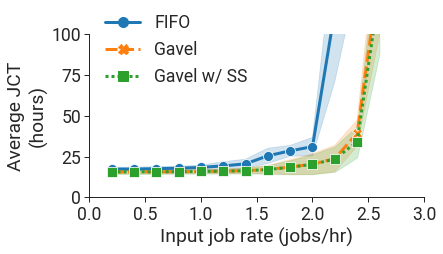

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
('Gavel', 0.2)
input_job_rate     0.200000
metric            17.291212
seed               1.000000
dtype: float64
('Gavel', 0.4)
input_job_rate     0.400000
metric            17.312775
seed               1.000000
dtype: float64
('Gavel', 0.6)
input_job_rate     0.600000
metric            17.331529
seed               1.000000
dtype: float64
('Gavel', 0.8)
input_job_rate     0.800000
metric            17.274679
seed               1.000000
dtype: float64
('Gavel', 1.0)
input_job_rate     1.000000
metric            17.216846
seed               1.000000
dtype: float64
('Gavel', 1.2)
input_job_rate     1.200000
metric            17.086312
seed               1.000000
dtype: float64
('Gavel', 1.4000000002333335)
input_job_rate     1.400000
metric            17.021867
seed               1.000000
dtype: float64
('Gavel', 1.6)
input_job_rate     1.600000
metric            17.192634
seed               1.000000
dtyp

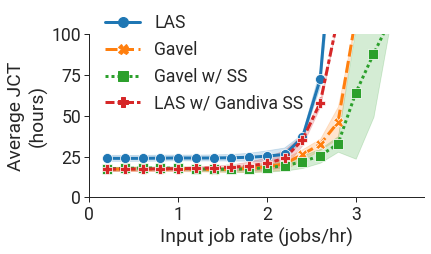

['finish_time_fairness', 'finish_time_fairness_perf']
('FTF', 0.2)
input_job_rate     0.200000
metric            23.913384
seed               1.000000
dtype: float64
('FTF', 0.4)
input_job_rate     0.400000
metric            23.867195
seed               1.000000
dtype: float64
('FTF', 0.6)
input_job_rate     0.600000
metric            23.898508
seed               1.000000
dtype: float64
('FTF', 0.8)
input_job_rate     0.800000
metric            24.009824
seed               1.000000
dtype: float64
('FTF', 1.0)
input_job_rate     1.00000
metric            24.16896
seed               1.00000
dtype: float64
('FTF', 1.2)
input_job_rate     1.200000
metric            24.102059
seed               1.000000
dtype: float64
('FTF', 1.4000000002333335)
input_job_rate     1.400000
metric            24.134485
seed               1.000000
dtype: float64
('FTF', 1.6)
input_job_rate     1.60000
metric            24.25566
seed               1.00000
dtype: float64
('FTF', 1.8)
input_job_rate     1.800000


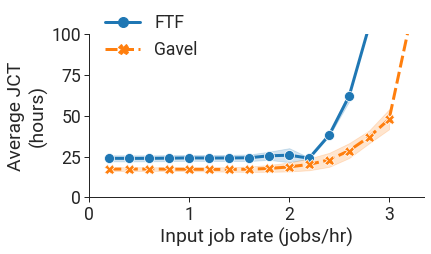

In [12]:
plot_metric_vs_inverse_lambda(
    v100s=36, p100s=36, k80s=36,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    xmax=3.0,
    ymax=100.0,
    extrapolate=False,
    output_filename="continuous_jobs/multi_gpu_fifo_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    v100s=36, p100s=36, k80s=36,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=False,
    output_filename="continuous_jobs/multi_gpu_las_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    v100s=36, p100s=36, k80s=36,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=True,
    output_filename="continuous_jobs/multi_gpu_ftf_v100=36_p100=36_k80=36.pdf"
)

['fifo', 'fifo_perf', 'fifo_packed']
Input job rate: 0.20
The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
fifo: 18.56
fifo_perf: 16.91
fifo_packed: 16.91


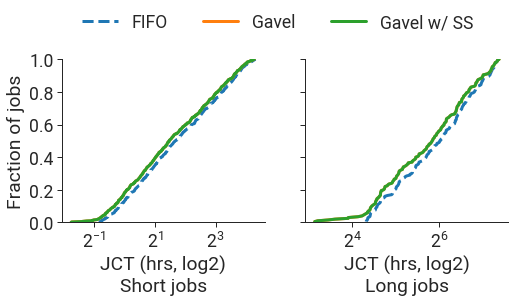

Input job rate: 0.40
fifo: 18.61
fifo_perf: 16.96
fifo_packed: 16.96


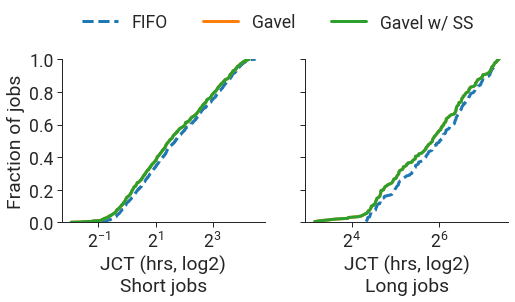

Input job rate: 0.60
fifo: 18.95
fifo_perf: 17.01
fifo_packed: 17.01


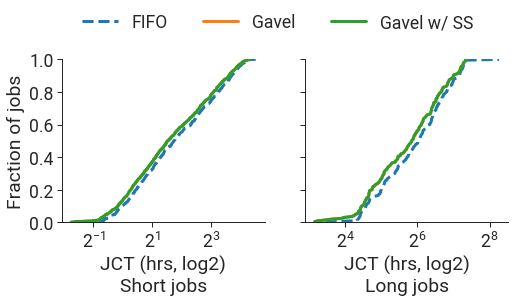

Input job rate: 0.80
fifo: 19.21
fifo_perf: 17.10
fifo_packed: 17.10


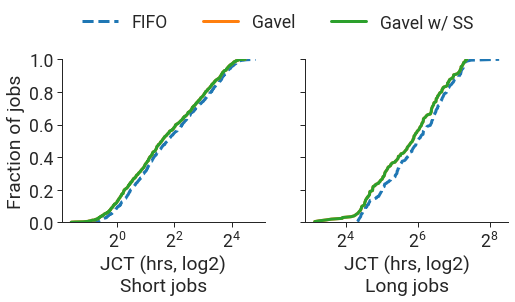

Input job rate: 1.00
fifo: 19.92
fifo_perf: 17.34
fifo_packed: 17.34


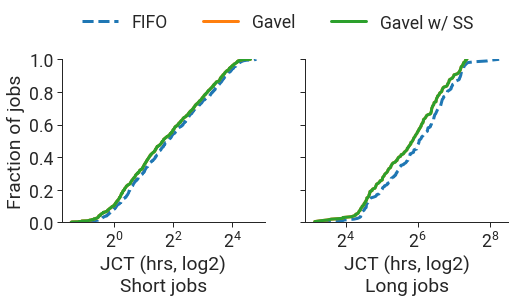

Input job rate: 1.20
fifo: 22.20
fifo_perf: 17.65
fifo_packed: 17.65


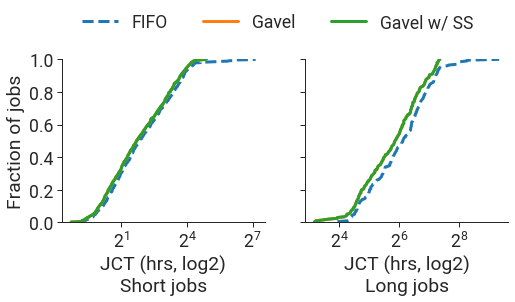

Input job rate: 1.40
fifo: 23.70
fifo_perf: 18.29
fifo_packed: 18.29


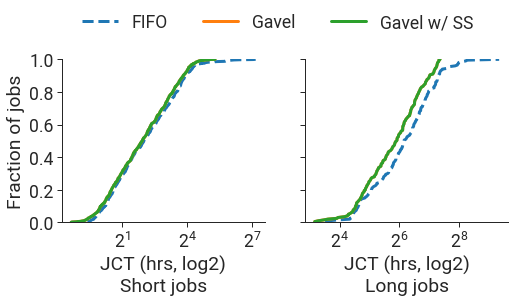

Input job rate: 1.60
fifo: 30.82
fifo_perf: 20.02
fifo_packed: 19.95


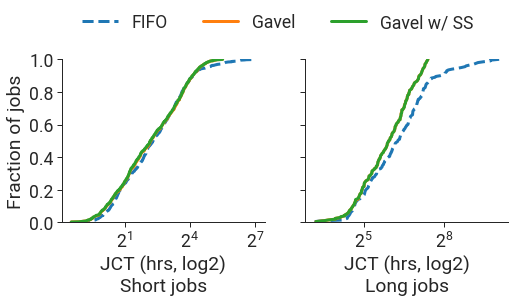

Input job rate: 1.80
fifo: 31.54
fifo_perf: 23.71
fifo_packed: 23.44


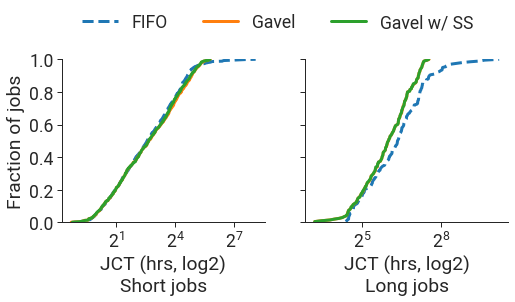

Input job rate: 2.00
fifo: 37.56
fifo_perf: 27.68
fifo_packed: 27.34


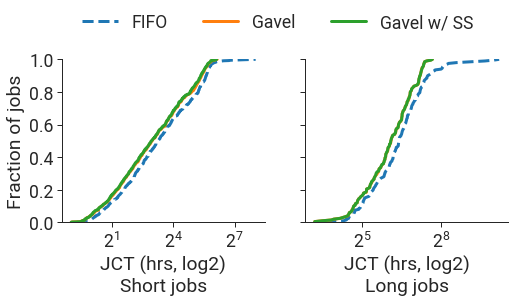

Input job rate: 2.20
fifo: 65.45
fifo_perf: 33.05
fifo_packed: 32.37


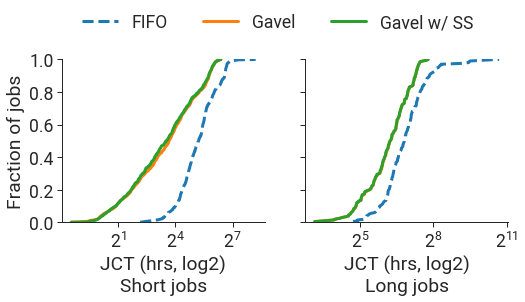

Input job rate: 2.40
fifo: 129.27
fifo_perf: 43.94
fifo_packed: 42.34


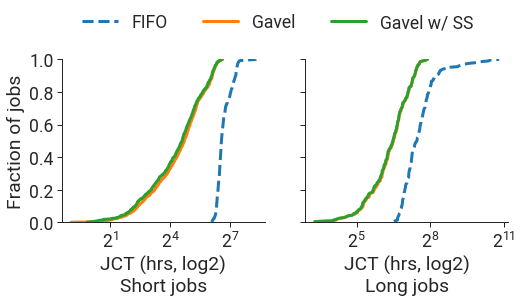

Input job rate: 2.60
fifo: 304.76
fifo_perf: 93.60
fifo_packed: 82.18


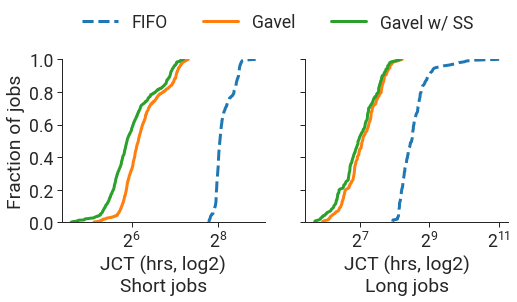

Input job rate: 2.80
fifo: 414.68
fifo_perf: 204.44


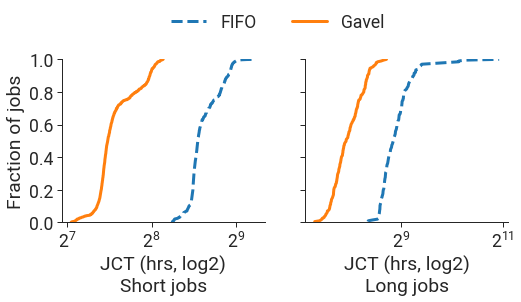

Input job rate: 3.00
fifo: 537.18
fifo_perf: 301.75


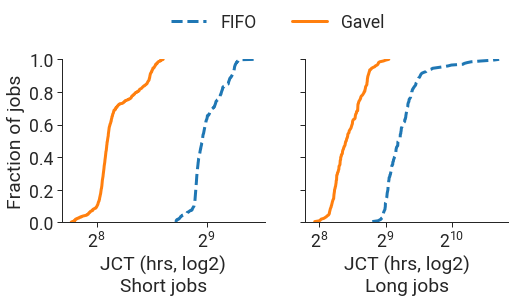

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
Input job rate: 0.20
max_min_fairness: 25.93
max_min_fairness_perf: 18.55
max_min_fairness_packed: 18.72
gandiva: 18.55


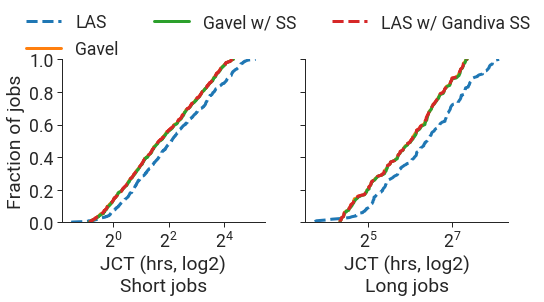

Input job rate: 0.40
max_min_fairness: 25.92
max_min_fairness_perf: 18.58
max_min_fairness_packed: 18.95
gandiva: 18.59


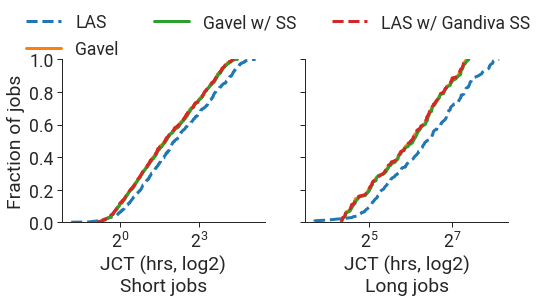

Input job rate: 0.60
max_min_fairness: 25.88
max_min_fairness_perf: 18.59
max_min_fairness_packed: 19.09
gandiva: 18.66


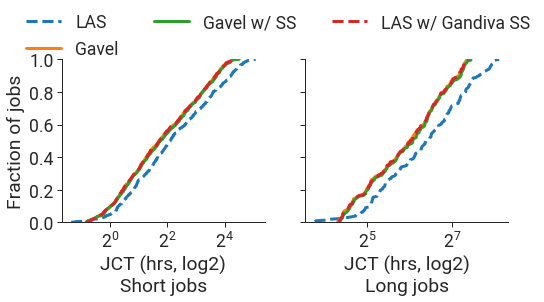

Input job rate: 0.80
max_min_fairness: 26.08
max_min_fairness_perf: 18.51
max_min_fairness_packed: 18.98
gandiva: 18.76


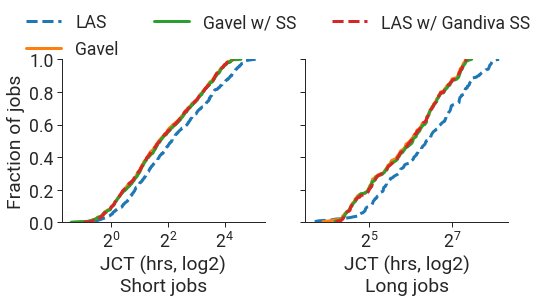

Input job rate: 1.00
max_min_fairness: 26.10
max_min_fairness_perf: 18.54
max_min_fairness_packed: 19.01
gandiva: 18.96


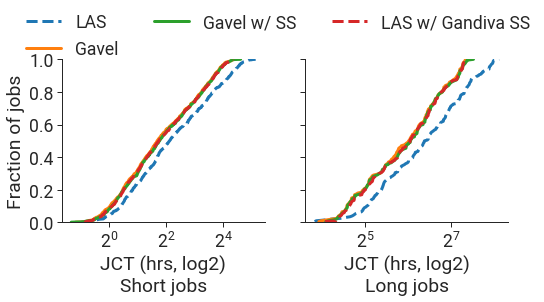

Input job rate: 1.20
max_min_fairness: 26.10
max_min_fairness_perf: 18.49
max_min_fairness_packed: 18.78
gandiva: 19.23


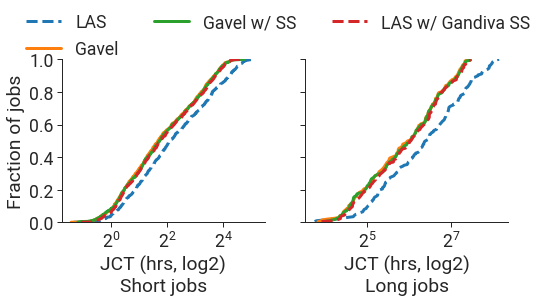

Input job rate: 1.40
max_min_fairness: 26.23
max_min_fairness_perf: 18.55
max_min_fairness_packed: 18.68
gandiva: 19.58


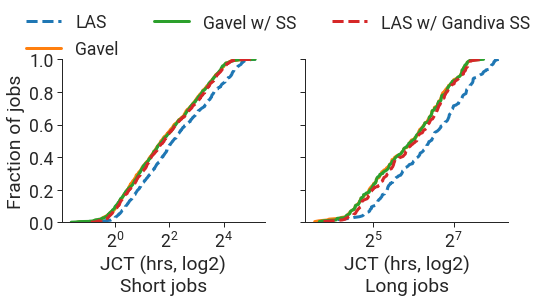

Input job rate: 1.60
max_min_fairness: 26.51
max_min_fairness_perf: 19.12
max_min_fairness_packed: 18.90
gandiva: 20.47


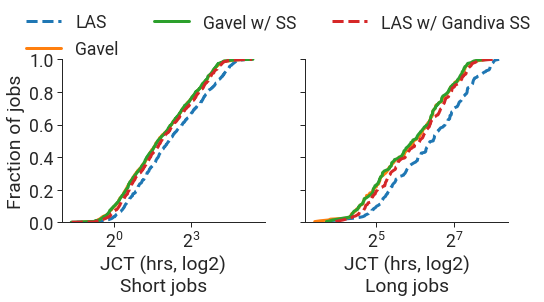

Input job rate: 1.80
max_min_fairness: 27.29
max_min_fairness_perf: 20.35
max_min_fairness_packed: 19.66
gandiva: 22.32


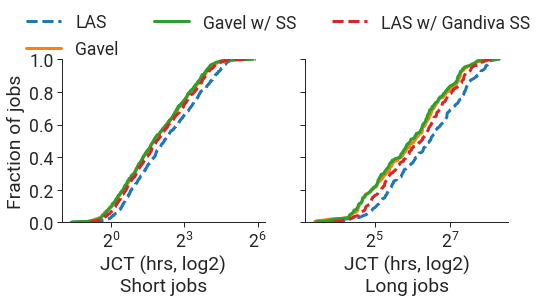

Input job rate: 2.00
max_min_fairness: 28.91
max_min_fairness_perf: 21.90
max_min_fairness_packed: 20.85
gandiva: 25.16


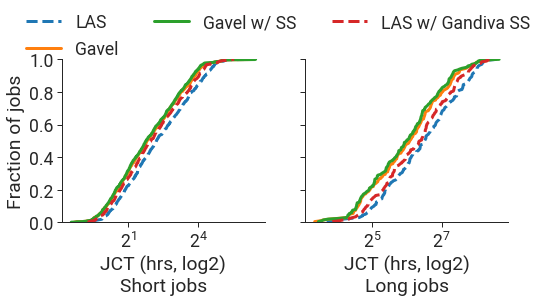

Input job rate: 2.20
max_min_fairness: 30.82
max_min_fairness_perf: 24.61
max_min_fairness_packed: 22.89
gandiva: 30.02


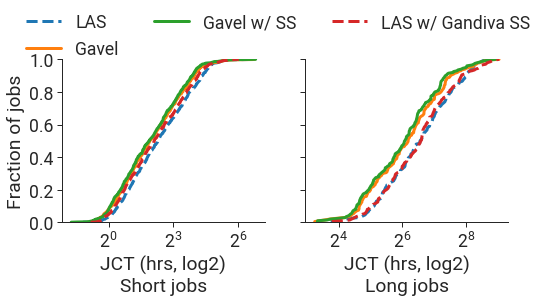

Input job rate: 2.40
max_min_fairness: 38.71
max_min_fairness_perf: 30.03
max_min_fairness_packed: 26.22
gandiva: 38.79


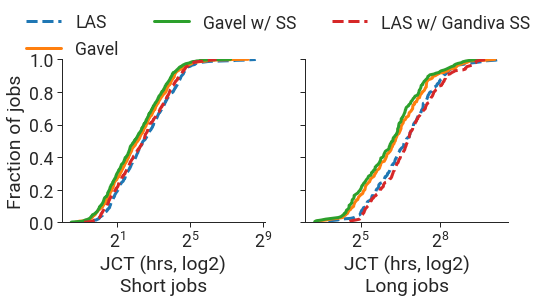

Input job rate: 2.60
max_min_fairness: 70.54
max_min_fairness_perf: 36.44
max_min_fairness_packed: 30.51
gandiva: 60.43


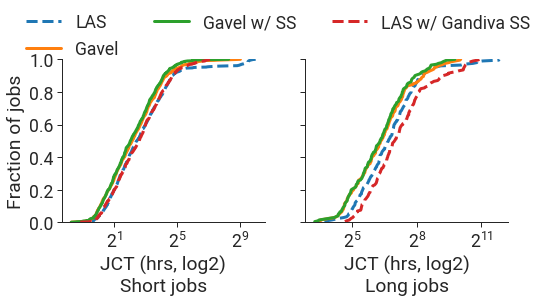

Input job rate: 2.80
max_min_fairness: 169.93
max_min_fairness_perf: 55.78
max_min_fairness_packed: 38.25


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


gandiva: nan


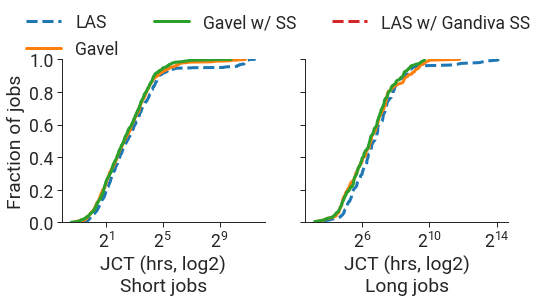

Input job rate: 3.00


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


max_min_fairness_perf: nan
max_min_fairness_packed: 46.94


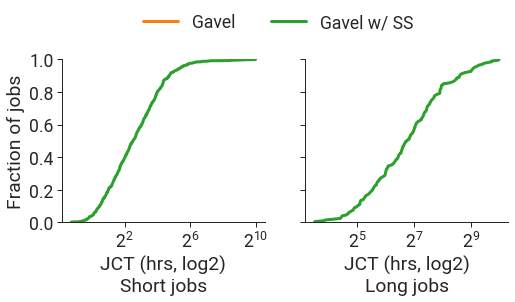

['finish_time_fairness', 'finish_time_fairness_perf']
Input job rate: 0.20
finish_time_fairness: 25.93
finish_time_fairness_perf: 18.55


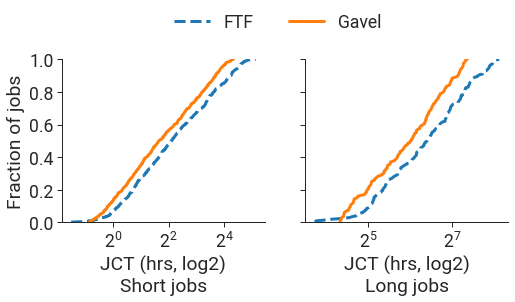

Input job rate: 0.40
finish_time_fairness: 25.92
finish_time_fairness_perf: 18.57


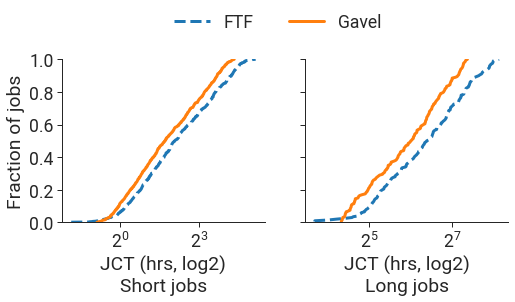

Input job rate: 0.60
finish_time_fairness: 25.89
finish_time_fairness_perf: 18.58


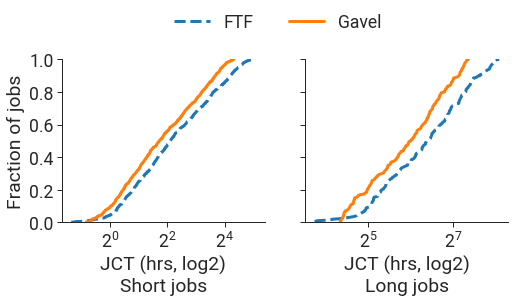

Input job rate: 0.80
finish_time_fairness: 26.06
finish_time_fairness_perf: 18.46


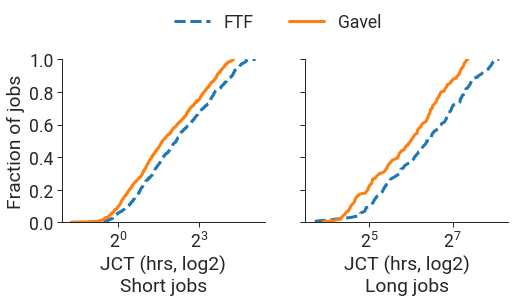

Input job rate: 1.00
finish_time_fairness: 26.12
finish_time_fairness_perf: 18.51


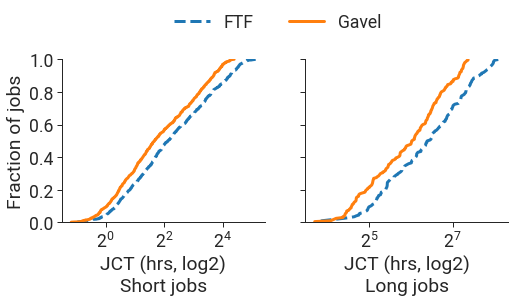

Input job rate: 1.20
finish_time_fairness: 26.12
finish_time_fairness_perf: 18.55


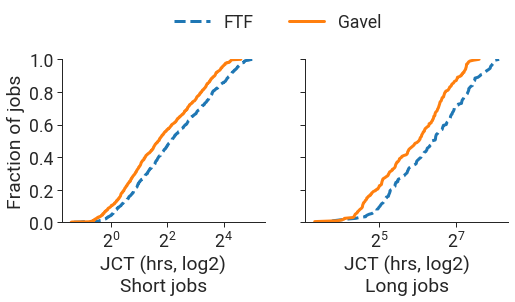

Input job rate: 1.40
finish_time_fairness: 26.24
finish_time_fairness_perf: 18.67


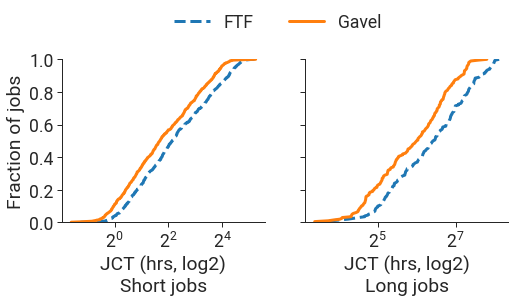

Input job rate: 1.60
finish_time_fairness: 26.50
finish_time_fairness_perf: 19.14


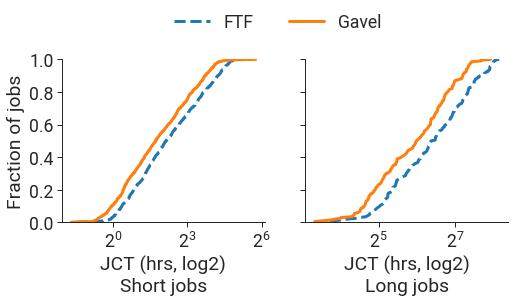

Input job rate: 1.80
finish_time_fairness: 27.23
finish_time_fairness_perf: 20.12


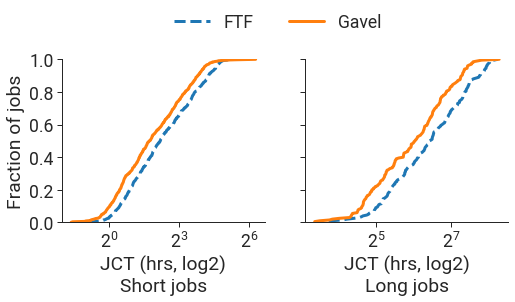

Input job rate: 2.00
finish_time_fairness: 28.87
finish_time_fairness_perf: 21.80


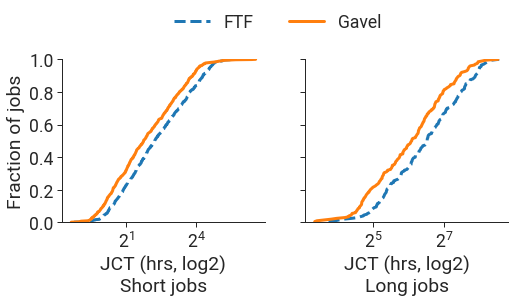

Input job rate: 2.20
finish_time_fairness_perf: 24.36


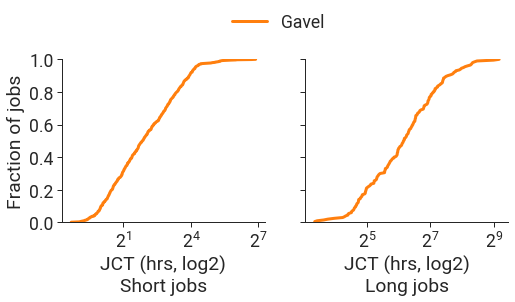

Input job rate: 2.40
finish_time_fairness: 38.65
finish_time_fairness_perf: 27.93


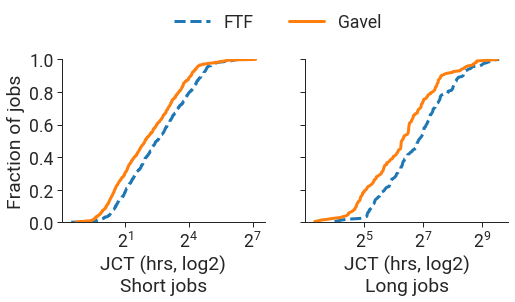

Input job rate: 2.60
finish_time_fairness: 64.38
finish_time_fairness_perf: 33.90


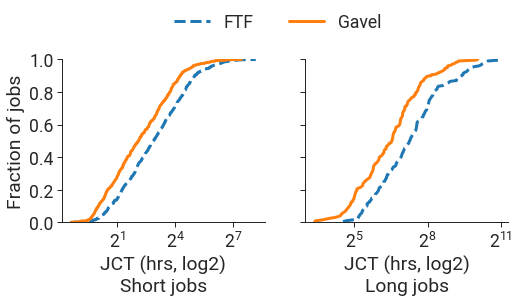

Input job rate: 2.80
finish_time_fairness_perf: 41.56


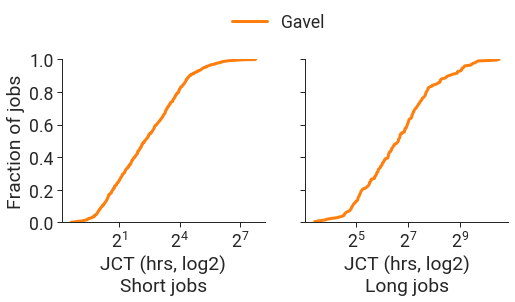

Input job rate: 3.00
finish_time_fairness_perf: 52.19


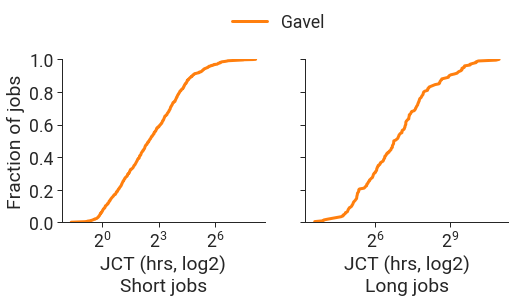

In [13]:
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/multi_gpu_fifo_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/multi_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/multi_gpu_ftf_v100=36_p100=36_k80=36/"
)

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
Input job rate: 0.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.82
gandiva: 0.80


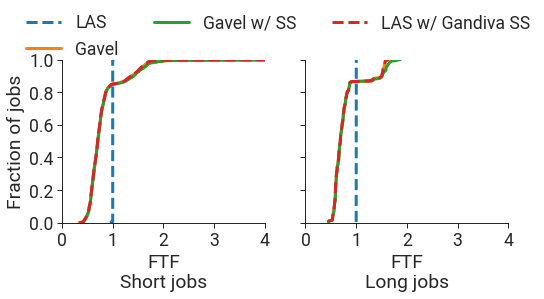

Input job rate: 0.40
max_min_fairness: 1.00
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.83
gandiva: 0.80


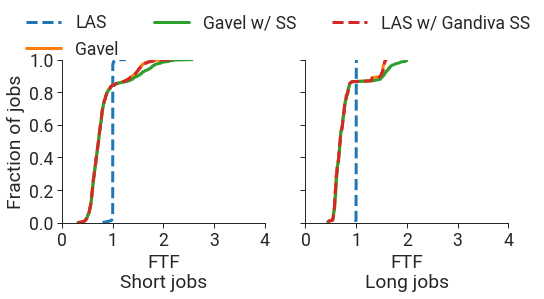

Input job rate: 0.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.84
gandiva: 0.80


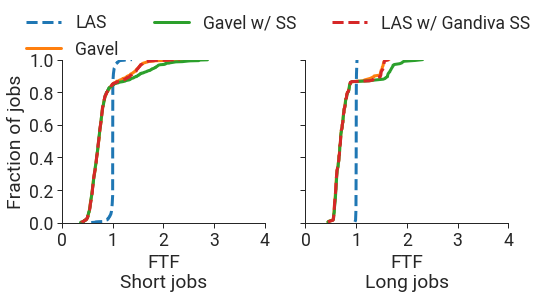

Input job rate: 0.80
max_min_fairness: 1.00
max_min_fairness_perf: 0.78
max_min_fairness_packed: 0.82
gandiva: 0.79


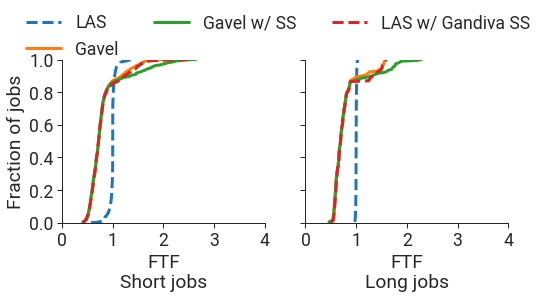

Input job rate: 1.00
max_min_fairness: 1.01
max_min_fairness_perf: 0.78
max_min_fairness_packed: 0.82
gandiva: 0.81


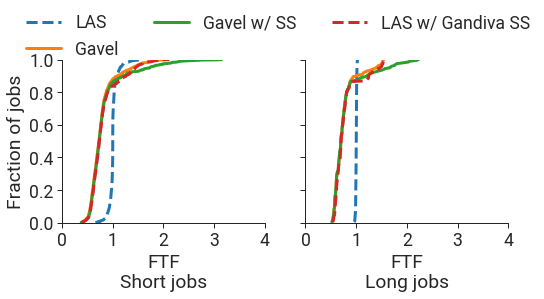

Input job rate: 1.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.76
max_min_fairness_packed: 0.79
gandiva: 0.81


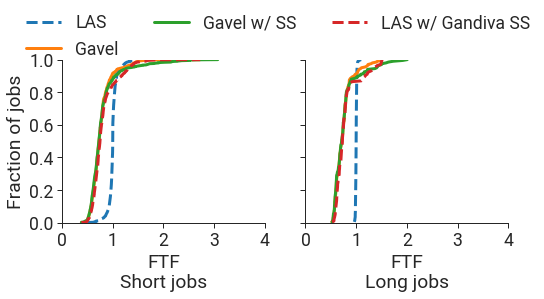

Input job rate: 1.40
max_min_fairness: 1.01
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.77
gandiva: 0.80


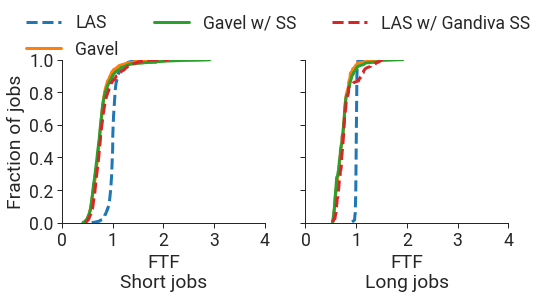

Input job rate: 1.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.76
max_min_fairness_packed: 0.75
gandiva: 0.83


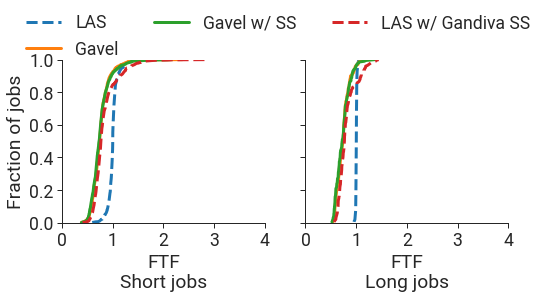

Input job rate: 1.80
max_min_fairness: 1.01
max_min_fairness_perf: 0.77
max_min_fairness_packed: 0.75
gandiva: 0.86


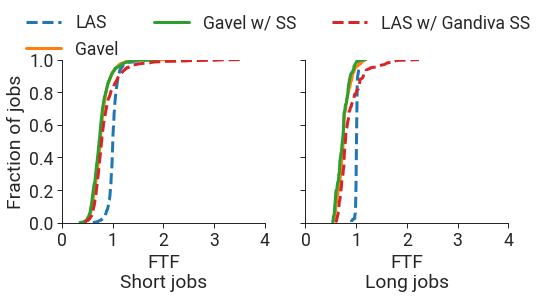

Input job rate: 2.00
max_min_fairness: 1.03
max_min_fairness_perf: 0.79
max_min_fairness_packed: 0.76
gandiva: 0.92


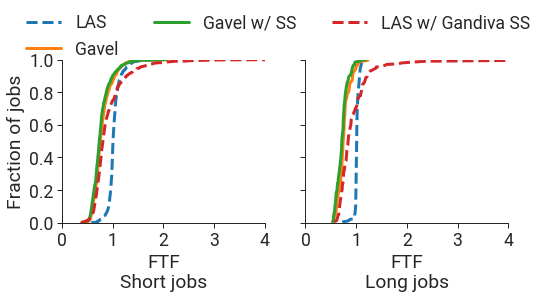

Input job rate: 2.20
max_min_fairness: 1.02
max_min_fairness_perf: 0.82
max_min_fairness_packed: 0.78
gandiva: 0.98


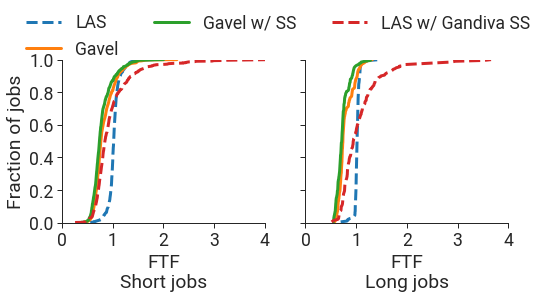

Input job rate: 2.40
max_min_fairness: 1.10
max_min_fairness_perf: 0.85
max_min_fairness_packed: 0.76
gandiva: 1.09


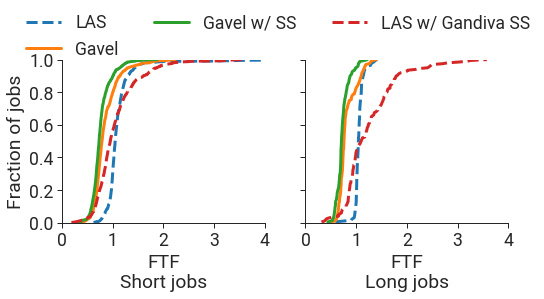

Input job rate: 2.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.81
max_min_fairness_packed: 0.76
gandiva: 1.23


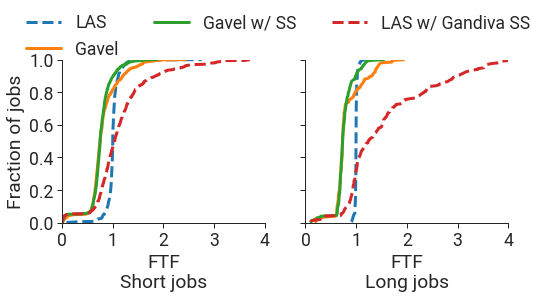

Input job rate: 2.80
max_min_fairness: 1.02
max_min_fairness_perf: 0.91
max_min_fairness_packed: 0.86


/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


gandiva: nan


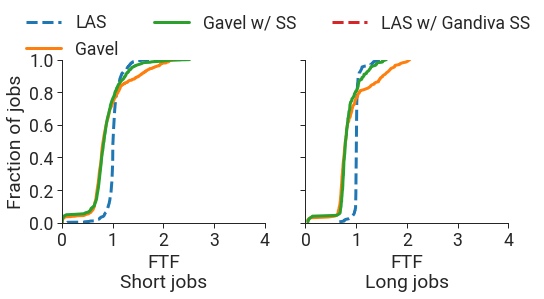

Input job rate: 3.00
['finish_time_fairness', 'finish_time_fairness_perf']
Input job rate: 0.20
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.80


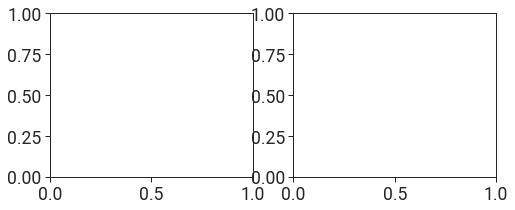

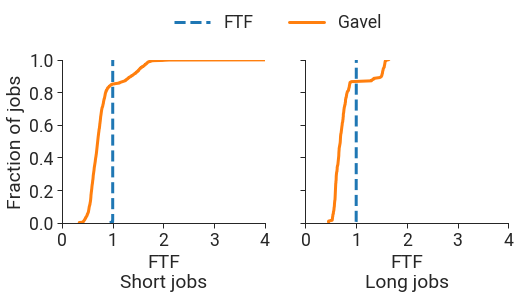

Input job rate: 0.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.80


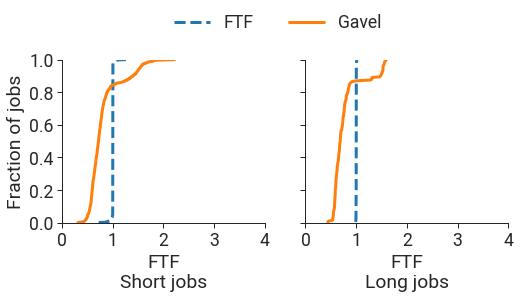

Input job rate: 0.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.80


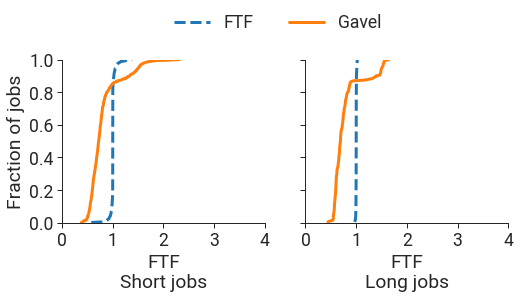

Input job rate: 0.80
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.77


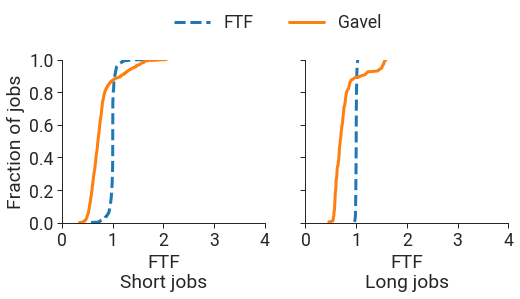

Input job rate: 1.00
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.77


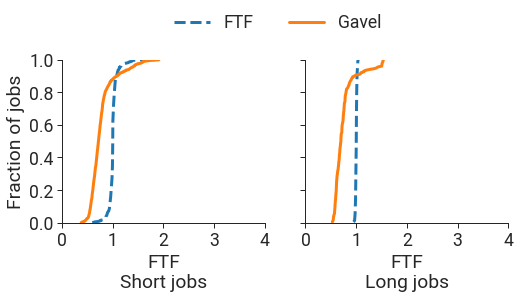

Input job rate: 1.20
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.76


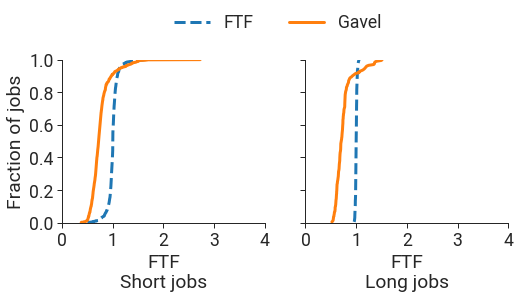

Input job rate: 1.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.74


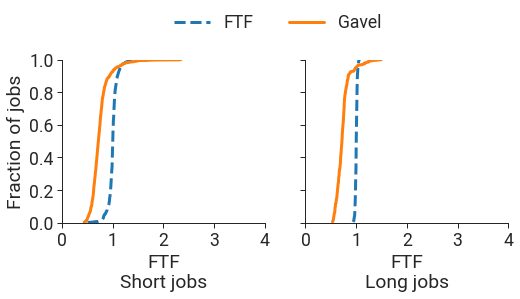

Input job rate: 1.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.75


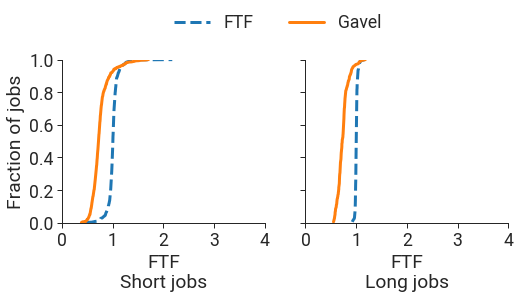

Input job rate: 1.80
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.75


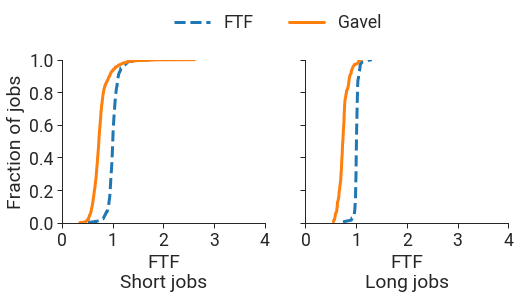

Input job rate: 2.00
finish_time_fairness: 1.02
finish_time_fairness_perf: 0.76


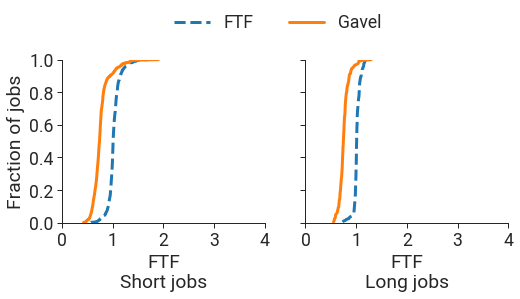

Input job rate: 2.20
finish_time_fairness_perf: 0.78


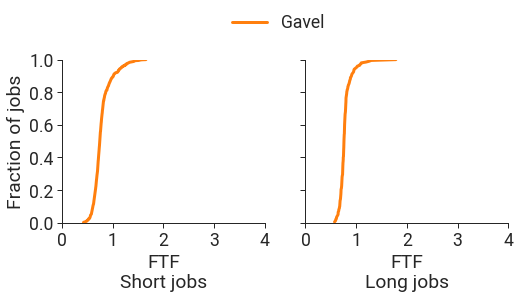

Input job rate: 2.40
finish_time_fairness: 1.12
finish_time_fairness_perf: 0.78


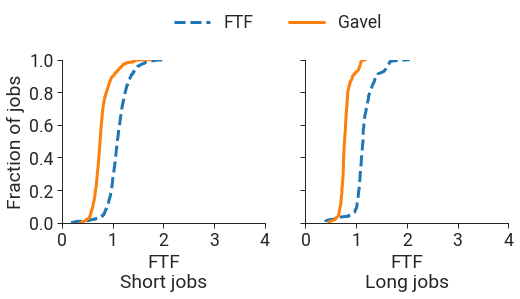

Input job rate: 2.60
finish_time_fairness: 1.40
finish_time_fairness_perf: 0.79


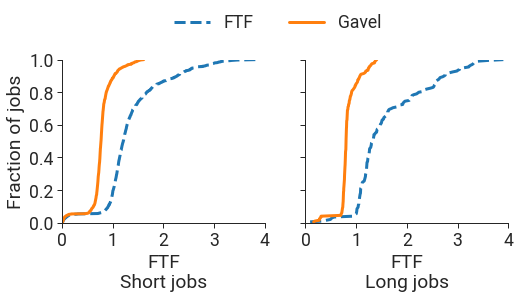

Input job rate: 2.80
finish_time_fairness_perf: 0.86


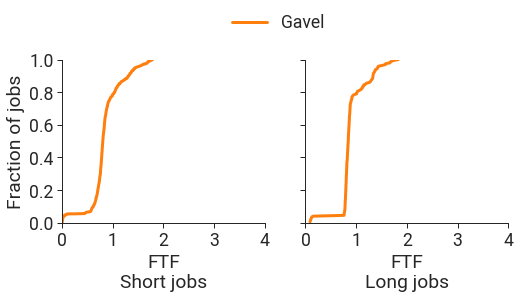

Input job rate: 3.00


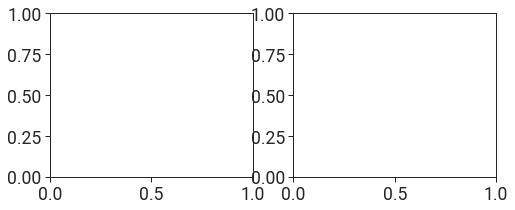

In [14]:
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/multi_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=3.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/multi_gpu_ftf_v100=36_p100=36_k80=36/"
)